## Packet Capturing

In [ ]:
import time
import threading
from scapy.all import sniff, IP, TCP, UDP
import pandas as pd
import numpy as np

class Flow:
    def __init__(self, src_ip, dst_ip, src_port, dst_port, proto):
        self.src_ip = src_ip
        self.dst_ip = dst_ip
        self.src_port = src_port
        self.dst_port = dst_port
        self.proto = proto

        self.packets = []          # List of packets (scapy packets)
        self.packet_times = []     # Timestamps of packets
        self.fwd_pkt_sizes = []    # Forward packet sizes
        self.bwd_pkt_sizes = []    # Backward packet sizes

        self.fwd_pkt_times = []    # Forward packet timestamps
        self.bwd_pkt_times = []    # Backward packet timestamps

        self.fwd_flags = []
        self.bwd_flags = []

        self.start_time = None
        self.end_time = None

    def add_packet(self, pkt, timestamp):
        if self.start_time is None:
            self.start_time = timestamp
        self.end_time = timestamp

        self.packets.append(pkt)
        self.packet_times.append(timestamp)

        # Determine direction: forward or backward
        if IP in pkt:
            ip_layer = pkt[IP]
            if (ip_layer.src == self.src_ip and ip_layer.dst == self.dst_ip):
                direction = 'fwd'
            else:
                direction = 'bwd'
        else:
            direction = 'fwd'  # fallback

        pkt_len = len(pkt)
        flags = 0
        if TCP in pkt:
            flags = pkt[TCP].flags

        if direction == 'fwd':
            self.fwd_pkt_sizes.append(pkt_len)
            self.fwd_pkt_times.append(timestamp)
            self.fwd_flags.append(flags)
        else:
            self.bwd_pkt_sizes.append(pkt_len)
            self.bwd_pkt_times.append(timestamp)
            self.bwd_flags.append(flags)

    def compute_features(self):
        # Helper stats
        def safe_mean(arr):
            return np.mean(arr) if len(arr) > 0 else 0
        def safe_std(arr):
            return np.std(arr) if len(arr) > 1 else 0
        def safe_max(arr):
            return np.max(arr) if len(arr) > 0 else 0
        def safe_min(arr):
            return np.min(arr) if len(arr) > 0 else 0
        def safe_var(arr):
            return np.var(arr) if len(arr) > 1 else 0

        flow_duration = self.end_time - self.start_time if self.end_time and self.start_time else 0

        total_fwd_packets = len(self.fwd_pkt_sizes)
        total_bwd_packets = len(self.bwd_pkt_sizes)

        total_length_fwd = sum(self.fwd_pkt_sizes)
        total_length_bwd = sum(self.bwd_pkt_sizes)

        fwd_pkt_len_max = safe_max(self.fwd_pkt_sizes)
        fwd_pkt_len_min = safe_min(self.fwd_pkt_sizes)
        fwd_pkt_len_mean = safe_mean(self.fwd_pkt_sizes)
        fwd_pkt_len_std = safe_std(self.fwd_pkt_sizes)

        bwd_pkt_len_max = safe_max(self.bwd_pkt_sizes)
        bwd_pkt_len_min = safe_min(self.bwd_pkt_sizes)
        bwd_pkt_len_mean = safe_mean(self.bwd_pkt_sizes)
        bwd_pkt_len_std = safe_std(self.bwd_pkt_sizes)

        flow_bytes_per_sec = (total_length_fwd + total_length_bwd) / flow_duration if flow_duration > 0 else 0
        flow_packets_per_sec = (total_fwd_packets + total_bwd_packets) / flow_duration if flow_duration > 0 else 0

        # Inter-arrival times (IAT)
        def iat_stats(timestamps):
            if len(timestamps) < 2:
                return 0, 0, 0, 0
            iats = np.diff(sorted(timestamps))
            return safe_mean(iats), safe_std(iats), safe_max(iats), safe_min(iats)

        flow_iat_mean, flow_iat_std, flow_iat_max, flow_iat_min = iat_stats(self.packet_times)
        fwd_iat_mean, fwd_iat_std, fwd_iat_max, fwd_iat_min = iat_stats(self.fwd_pkt_times)
        bwd_iat_mean, bwd_iat_std, bwd_iat_max, bwd_iat_min = iat_stats(self.bwd_pkt_times)

        # IAT totals (sum of IATs)
        fwd_iat_total = sum(np.diff(sorted(self.fwd_pkt_times))) if len(self.fwd_pkt_times) > 1 else 0
        bwd_iat_total = sum(np.diff(sorted(self.bwd_pkt_times))) if len(self.bwd_pkt_times) > 1 else 0

        # Count flags (for TCP only, convert to int for bitmask)
        def count_flags(flags_list, flag_mask):
            return sum([1 for f in flags_list if f & flag_mask != 0])

        # TCP flag masks (from scapy)
        FIN = 0x01
        SYN = 0x02
        RST = 0x04
        PSH = 0x08
        ACK = 0x10
        URG = 0x20
        ECE = 0x40
        CWR = 0x80

        fwd_fin_count = count_flags(self.fwd_flags, FIN)
        fwd_syn_count = count_flags(self.fwd_flags, SYN)
        fwd_rst_count = count_flags(self.fwd_flags, RST)
        fwd_psh_count = count_flags(self.fwd_flags, PSH)
        fwd_ack_count = count_flags(self.fwd_flags, ACK)
        fwd_urg_count = count_flags(self.fwd_flags, URG)
        fwd_ece_count = count_flags(self.fwd_flags, ECE)
        fwd_cwr_count = count_flags(self.fwd_flags, CWR)

        bwd_fin_count = count_flags(self.bwd_flags, FIN)
        bwd_syn_count = count_flags(self.bwd_flags, SYN)
        bwd_rst_count = count_flags(self.bwd_flags, RST)
        bwd_psh_count = count_flags(self.bwd_flags, PSH)
        bwd_ack_count = count_flags(self.bwd_flags, ACK)
        bwd_urg_count = count_flags(self.bwd_flags, URG)
        bwd_ece_count = count_flags(self.bwd_flags, ECE)
        bwd_cwr_count = count_flags(self.bwd_flags, CWR)

        # Combine flags counts
        fin_flag_count = fwd_fin_count + bwd_fin_count
        syn_flag_count = fwd_syn_count + bwd_syn_count
        rst_flag_count = fwd_rst_count + bwd_rst_count
        psh_flag_count = fwd_psh_count + bwd_psh_count
        ack_flag_count = fwd_ack_count + bwd_ack_count
        urg_flag_count = fwd_urg_count + bwd_urg_count
        cwe_flag_count = fwd_cwr_count + bwd_cwr_count  # CWR = CWE here
        ece_flag_count = fwd_ece_count + bwd_ece_count

        # Packet length stats (both directions)
        all_pkt_sizes = self.fwd_pkt_sizes + self.bwd_pkt_sizes
        min_pkt_len = safe_min(all_pkt_sizes)
        max_pkt_len = safe_max(all_pkt_sizes)
        pkt_len_mean = safe_mean(all_pkt_sizes)
        pkt_len_std = safe_std(all_pkt_sizes)
        pkt_len_var = safe_var(all_pkt_sizes)

        # Down/Up ratio (ratio of forward to backward bytes)
        down_up_ratio = (total_length_fwd / total_length_bwd) if total_length_bwd > 0 else 0

        # Average packet size
        avg_pkt_size = np.mean(all_pkt_sizes) if len(all_pkt_sizes) > 0 else 0

        # Average forward segment size (mean fwd packet size)
        avg_fwd_seg_size = fwd_pkt_len_mean

        # Average backward segment size (mean bwd packet size)
        avg_bwd_seg_size = bwd_pkt_len_mean

        # Header length sums (approximate: TCP header length * count)
        fwd_header_length = 0
        bwd_header_length = 0
        for pkt in self.packets:
            if TCP in pkt:
                tcp_header_len = pkt[TCP].dataofs * 4  # dataofs is number of 32-bit words
                ip_layer = pkt[IP]
                if ip_layer.src == self.src_ip:
                    fwd_header_length += tcp_header_len
                else:
                    bwd_header_length += tcp_header_len

        # Fwd Header Length.1 (not sure what this is, repeat fwd header length)
        fwd_header_length_1 = fwd_header_length

        # Bulk stats: simplified placeholders (since real bulk detection is complex)
        fwd_avg_bytes_bulk = total_length_fwd / total_fwd_packets if total_fwd_packets > 0 else 0
        fwd_avg_packets_bulk = total_fwd_packets
        fwd_avg_bulk_rate = flow_bytes_per_sec

        bwd_avg_bytes_bulk = total_length_bwd / total_bwd_packets if total_bwd_packets > 0 else 0
        bwd_avg_packets_bulk = total_bwd_packets
        bwd_avg_bulk_rate = flow_bytes_per_sec

        # Subflow packets and bytes (simplified: assume 1 subflow)
        subflow_fwd_packets = total_fwd_packets
        subflow_fwd_bytes = total_length_fwd
        subflow_bwd_packets = total_bwd_packets
        subflow_bwd_bytes = total_length_bwd

        # Initial window bytes (approximate from first TCP packet window size)
        init_win_bytes_forward = 0
        init_win_bytes_backward = 0
        for pkt in self.packets:
            if TCP in pkt:
                ip_layer = pkt[IP]
                if ip_layer.src == self.src_ip and init_win_bytes_forward == 0:
                    init_win_bytes_forward = pkt[TCP].window
                elif ip_layer.src == self.dst_ip and init_win_bytes_backward == 0:
                    init_win_bytes_backward = pkt[TCP].window

        # Active and idle times (simplified using packet timestamps)
        timestamps_sorted = sorted(self.packet_times)
        active_durations = []
        idle_durations = []

        if len(timestamps_sorted) > 1:
            for i in range(1, len(timestamps_sorted)):
                delta = timestamps_sorted[i] - timestamps_sorted[i-1]
                if delta < 1.0:  # active if gap < 1 sec
                    active_durations.append(delta)
                else:
                    idle_durations.append(delta)

        active_mean = safe_mean(active_durations)
        active_std = safe_std(active_durations)
        active_max = safe_max(active_durations)
        active_min = safe_min(active_durations)

        idle_mean = safe_mean(idle_durations)
        idle_std = safe_std(idle_durations)
        idle_max = safe_max(idle_durations)
        idle_min = safe_min(idle_durations)

        # Compose feature dict in requested order:
        feature_dict = {
            'Destination Port': self.dst_port,
            'Flow Duration': flow_duration,
            'Total Fwd Packets': total_fwd_packets,
            'Total Backward Packets': total_bwd_packets,
            'Total Length of Fwd Packets': total_length_fwd,
            'Total Length of Bwd Packets': total_length_bwd,
            'Fwd Packet Length Max': fwd_pkt_len_max,
            'Fwd Packet Length Min': fwd_pkt_len_min,
            'Fwd Packet Length Mean': fwd_pkt_len_mean,
            'Fwd Packet Length Std': fwd_pkt_len_std,
            'Bwd Packet Length Max': bwd_pkt_len_max,
            'Bwd Packet Length Min': bwd_pkt_len_min,
            'Bwd Packet Length Mean': bwd_pkt_len_mean,
            'Bwd Packet Length Std': bwd_pkt_len_std,
            'Flow Bytes/s': flow_bytes_per_sec,
            'Flow Packets/s': flow_packets_per_sec,
            'Flow IAT Mean': flow_iat_mean,
            'Flow IAT Std': flow_iat_std,
            'Flow IAT Max': flow_iat_max,
            'Flow IAT Min': flow_iat_min,
            'Fwd IAT Total': fwd_iat_total,
            'Fwd IAT Mean': fwd_iat_mean,
            'Fwd IAT Std': fwd_iat_std,
            'Fwd IAT Max': fwd_iat_max,
            'Fwd IAT Min': fwd_iat_min,
            'Bwd IAT Total': bwd_iat_total,
            'Bwd IAT Mean': bwd_iat_mean,
            'Bwd IAT Std': bwd_iat_std,
            'Bwd IAT Max': bwd_iat_max,
            'Bwd IAT Min': bwd_iat_min,
            'Fwd PSH Flags': fwd_psh_count,
            'Bwd PSH Flags': bwd_psh_count,
            'Fwd URG Flags': fwd_urg_count,
            'Bwd URG Flags': bwd_urg_count,
            'Fwd Header Length': fwd_header_length,
            'Bwd Header Length': bwd_header_length,
            'Fwd Packets/s': total_fwd_packets / flow_duration if flow_duration > 0 else 0,
            'Bwd Packets/s': total_bwd_packets / flow_duration if flow_duration > 0 else 0,
            'Min Packet Length': min_pkt_len,
            'Max Packet Length': max_pkt_len,
            'Packet Length Mean': pkt_len_mean,
            'Packet Length Std': pkt_len_std,
            'Packet Length Variance': pkt_len_var,
            'FIN Flag Count': fin_flag_count,
            'SYN Flag Count': syn_flag_count,
            'RST Flag Count': rst_flag_count,
            'PSH Flag Count': psh_flag_count,
            'ACK Flag Count': ack_flag_count,
            'URG Flag Count': urg_flag_count,
            'CWE Flag Count': cwe_flag_count,
            'ECE Flag Count': ece_flag_count,
            'Down/Up Ratio': down_up_ratio,
            'Average Packet Size': avg_pkt_size,
            'Avg Fwd Segment Size': avg_fwd_seg_size,
            'Avg Bwd Segment Size': avg_bwd_seg_size,
            'Fwd Header Length.1': fwd_header_length_1,
            'Fwd Avg Bytes/Bulk': fwd_avg_bytes_bulk,
            'Fwd Avg Packets/Bulk': fwd_avg_packets_bulk,
            'Fwd Avg Bulk Rate': fwd_avg_bulk_rate,
            'Bwd Avg Bytes/Bulk': bwd_avg_bytes_bulk,
            'Bwd Avg Packets/Bulk': bwd_avg_packets_bulk,
            'Bwd Avg Bulk Rate': bwd_avg_bulk_rate,
            'Subflow Fwd Packets': subflow_fwd_packets,
            'Subflow Fwd Bytes': subflow_fwd_bytes,
            'Subflow Bwd Packets': subflow_bwd_packets,
            'Subflow Bwd Bytes': subflow_bwd_bytes,
            'Init_Win_bytes_forward': init_win_bytes_forward,
            'Init_Win_bytes_backward': init_win_bytes_backward,
            'Active Mean': active_mean,
            'Active Std': active_std,
            'Active Max': active_max,
            'Active Min': active_min,
            'Idle Mean': idle_mean,
            'Idle Std': idle_std,
            'Idle Max': idle_max,
            'Idle Min': idle_min,
        }
        return feature_dict


# === Main sniffing and flow building ===
class FlowExtractor:
    def __init__(self):
        self.flows = {}

    def packet_callback(self, pkt):
        if IP not in pkt:
            return

        ip_layer = pkt[IP]
        proto = None
        src_port = None
        dst_port = None

        if TCP in pkt:
            proto = 'TCP'
            src_port = pkt[TCP].sport
            dst_port = pkt[TCP].dport
        elif UDP in pkt:
            proto = 'UDP'
            src_port = pkt[UDP].sport
            dst_port = pkt[UDP].dport
        else:
            proto = str(ip_layer.proto)
            src_port = 0
            dst_port = 0

        flow_key = (ip_layer.src, ip_layer.dst, src_port, dst_port, proto)
        rev_flow_key = (ip_layer.dst, ip_layer.src, dst_port, src_port, proto)

        timestamp = pkt.time

        # Check if flow or reverse flow exists (to merge bi-directional packets)
        if flow_key in self.flows:
            self.flows[flow_key].add_packet(pkt, timestamp)
        elif rev_flow_key in self.flows:
            self.flows[rev_flow_key].add_packet(pkt, timestamp)
        else:
            flow = Flow(ip_layer.src, ip_layer.dst, src_port, dst_port, proto)
            flow.add_packet(pkt, timestamp)
            self.flows[flow_key] = flow

    def run_sniffer(self, iface='eth0', timeout=60):
        print(f"Starting sniffing on {iface} for {timeout} seconds...")
        sniff(iface=iface, prn=self.packet_callback, timeout=timeout)
        print("Sniffing finished.")

    def extract_features(self):
        feature_dicts = []
        for flow_key, flow in self.flows.items():
            features = flow.compute_features()
            feature_dicts.append(features)
        return feature_dicts


if __name__ == '__main__':
    iface = 'Wi-Fi'  # change to your interface name
    timeout = 60    # seconds to sniff

    extractor = FlowExtractor()
    extractor.run_sniffer(iface=iface, timeout=timeout)

    print(f"Extracted {len(extractor.flows)} flows.")

    features = extractor.extract_features()
    df = pd.DataFrame(features)
    print(df.head())

    # Save to CSV
    df.to_csv('flow_features.csv', index=False)
    print("Saved flow features to flow_features.csv")


Starting sniffing on Wi-Fi for 60 seconds...
Sniffing finished.
Extracted 32 flows.
   Destination Port  Flow Duration  Total Fwd Packets  Total Backward Packets  \
0             53281       2.962359                  5                       8   
1             53283       0.337408                  4                       3   
2             53284       0.614118                  8                       7   
3              4070      25.854348                  4                       2   
4               443       0.385677                  1                       1   

   Total Length of Fwd Packets  Total Length of Bwd Packets  \
0                          368                         5071   
1                          784                          186   
2                         5531                         4442   
3                          923                          174   
4                           54                           54   

   Fwd Packet Length Max  Fwd Packet Length Min  F

In [ ]:
import pandas as pd
dff=pd.read_csv('Datasets/flow_features.csv')
dff.head()


,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,Init_Win_bytes_forward,Init_Win_bytes_backward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
0,53281,2.962359,5,8,368,5071,152,54,73.600,39.200000,...,16383,253,0.119709,0.205790,0.643778,0.000000,1.645557,0.0,1.645557,1.645557
1,53283,0.337408,4,3,784,186,519,54,196.000,191.166158,...,16385,253,0.056235,0.122632,0.330433,0.000000,0.000000,0.0,0.000000,0.000000
2,53284,0.614118,8,7,5531,4442,1514,54,691.375,651.388889,...,16381,255,0.043866,0.106682,0.330252,0.000000,0.000000,0.0,0.000000,0.000000
3,4070,25.854348,4,2,923,174,750,54,230.750,299.822760,...,255,6,0.132029,0.088683,0.234810,0.042142,25.326233,0.0,25.326233,25.326233
4,443,0.385677,1,1,54,54,54,54,54.000,0.000000,...,253,0,0.385677,0.000000,0.385677,0.385677,0.000000,0.0,0.000000,0.000000


In [20]:
test_data=pd.DataFrame()
test_data=dff.copy()
test_data['Label']=0

In [24]:
test_data.head()

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,Init_Win_bytes_backward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,53281,2.962359,5,8,368,5071,152,54,73.600,39.200000,...,253,0.119709,0.205790,0.643778,0.000000,1.645557,0.0,1.645557,1.645557,0
1,53283,0.337408,4,3,784,186,519,54,196.000,191.166158,...,253,0.056235,0.122632,0.330433,0.000000,0.000000,0.0,0.000000,0.000000,0
2,53284,0.614118,8,7,5531,4442,1514,54,691.375,651.388889,...,255,0.043866,0.106682,0.330252,0.000000,0.000000,0.0,0.000000,0.000000,0
3,4070,25.854348,4,2,923,174,750,54,230.750,299.822760,...,6,0.132029,0.088683,0.234810,0.042142,25.326233,0.0,25.326233,25.326233,0
4,443,0.385677,1,1,54,54,54,54,54.000,0.000000,...,0,0.385677,0.000000,0.385677,0.385677,0.000000,0.0,0.000000,0.000000,0


In [25]:
# Checking any null value
dff.isnull().sum()

Destination Port               0
Flow Duration                  0
Total Fwd Packets              0
Total Backward Packets         0
Total Length of Fwd Packets    0
                              ..
Active Min                     0
Idle Mean                      0
Idle Std                       0
Idle Max                       0
Idle Min                       0
Length: 76, dtype: int64

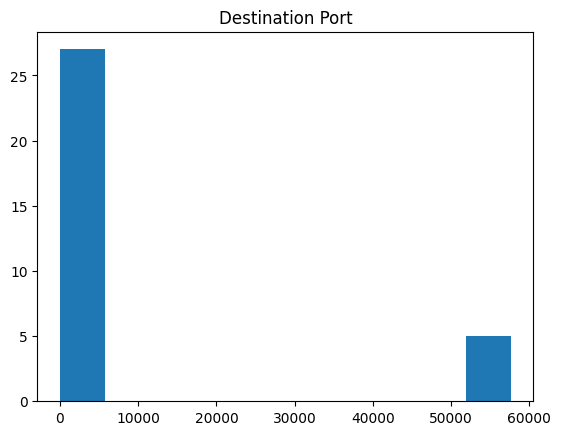

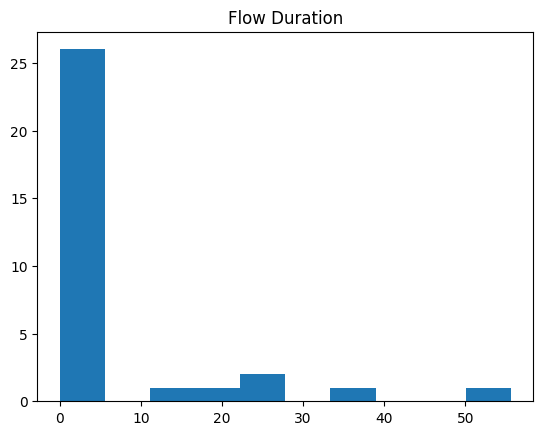

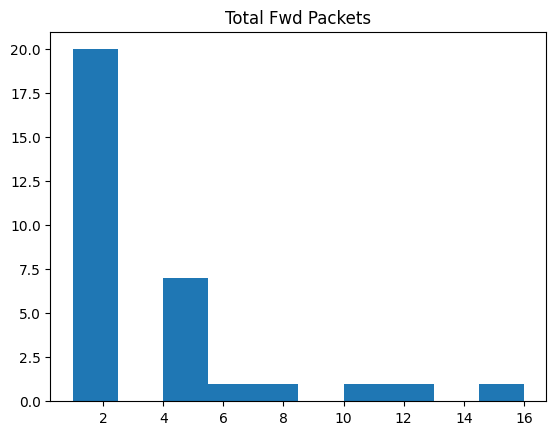

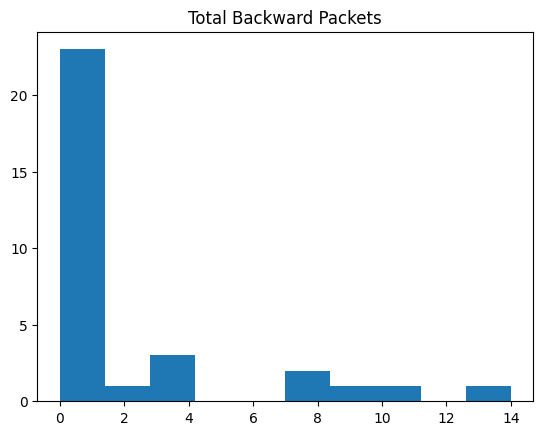

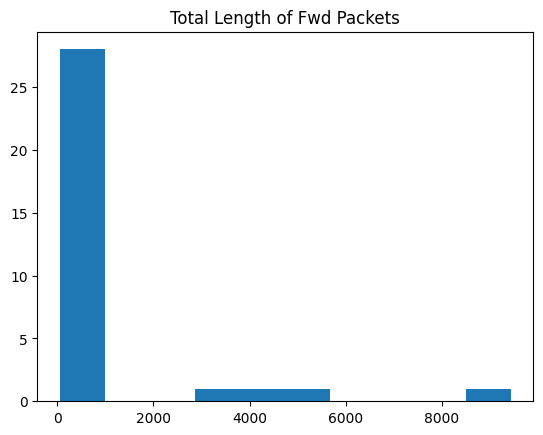

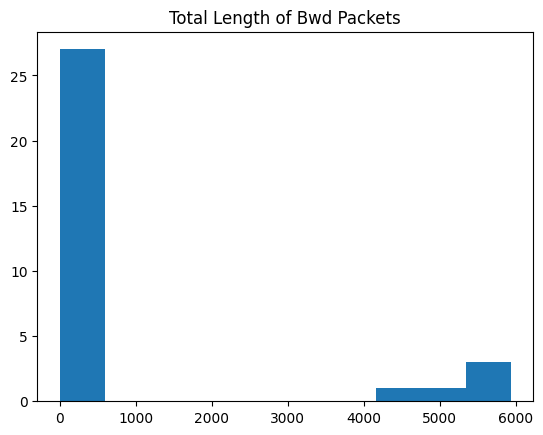

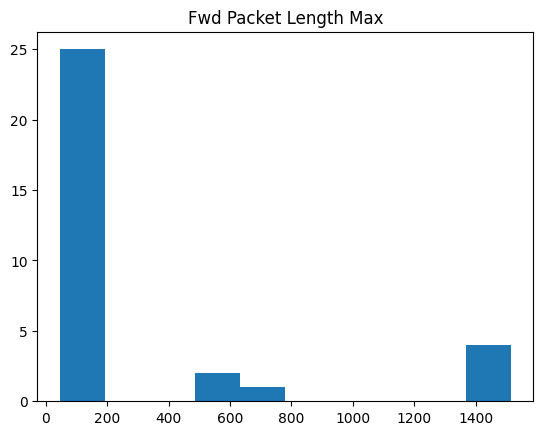

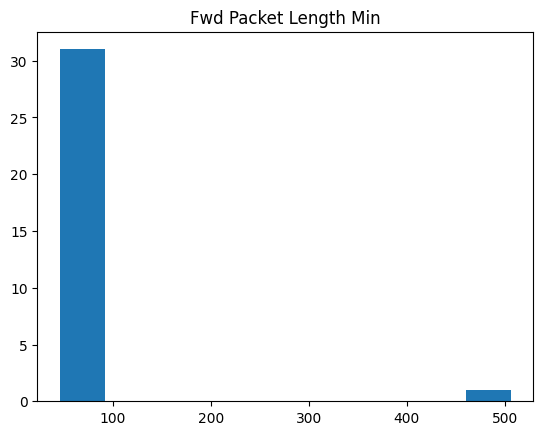

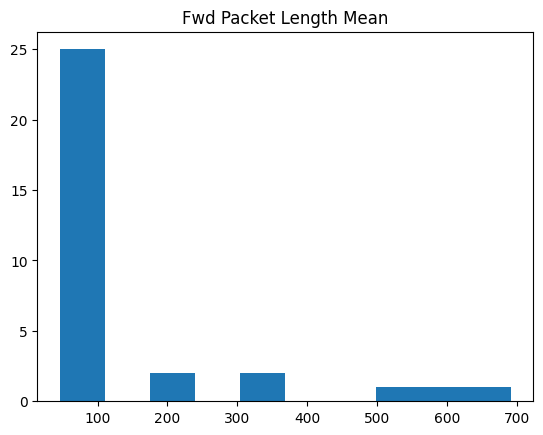

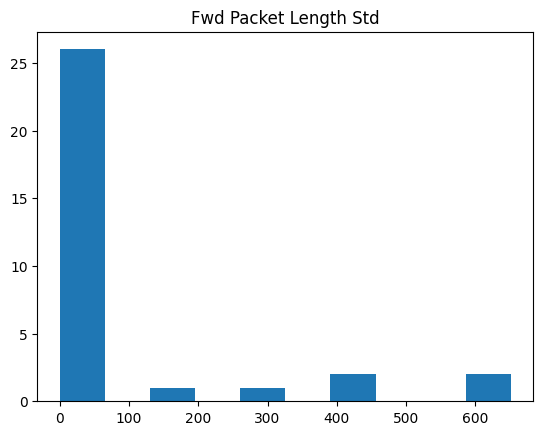

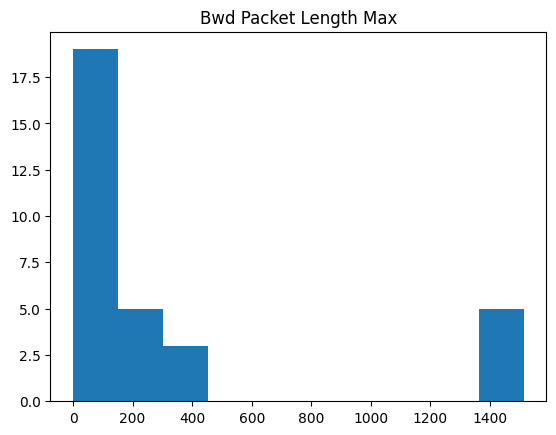

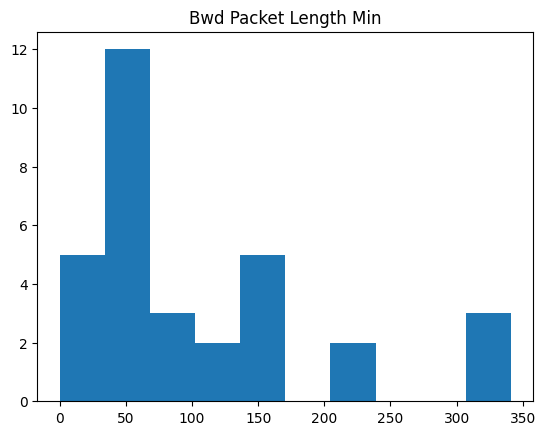

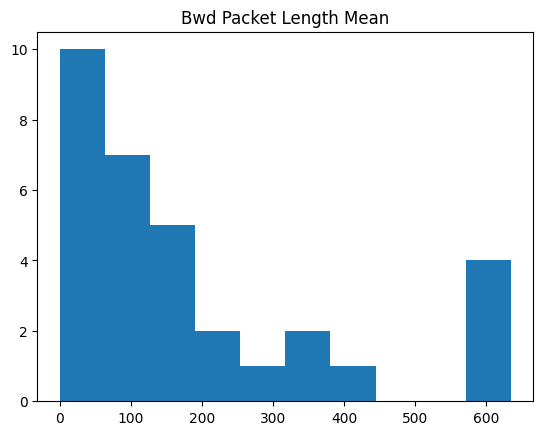

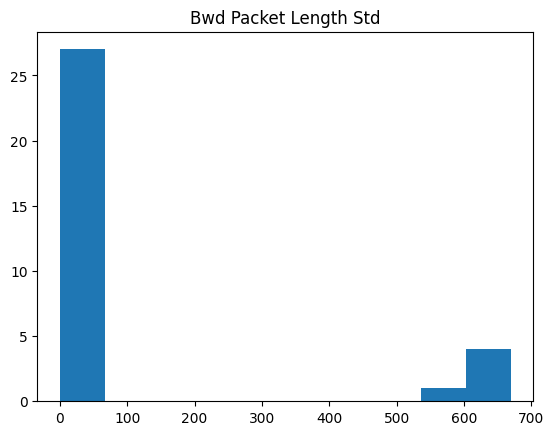

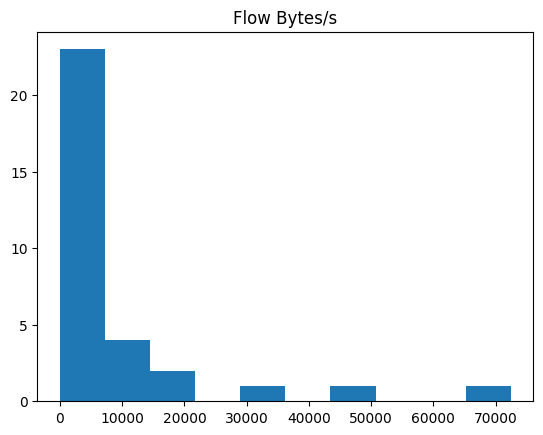

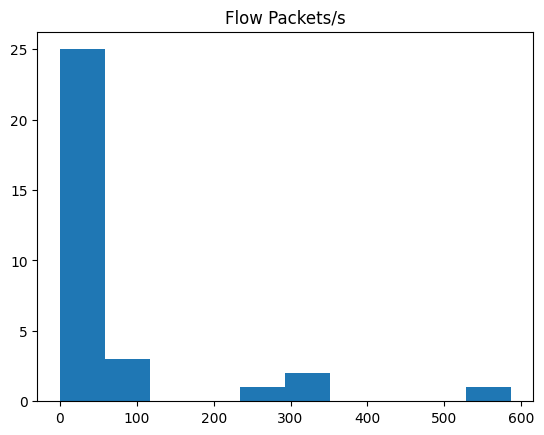

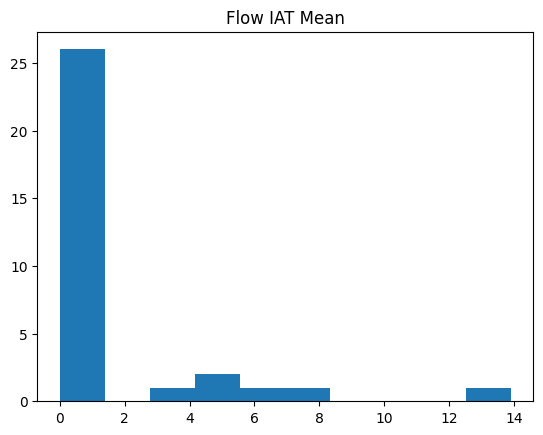

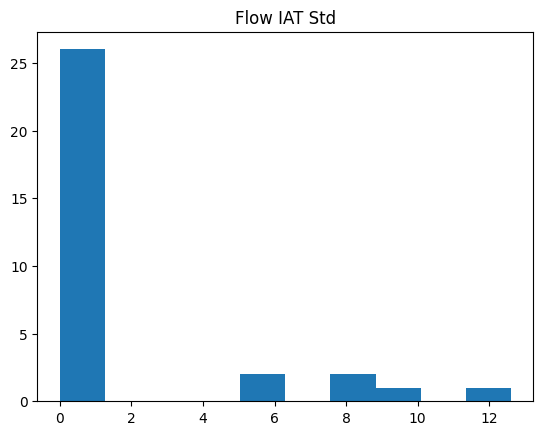

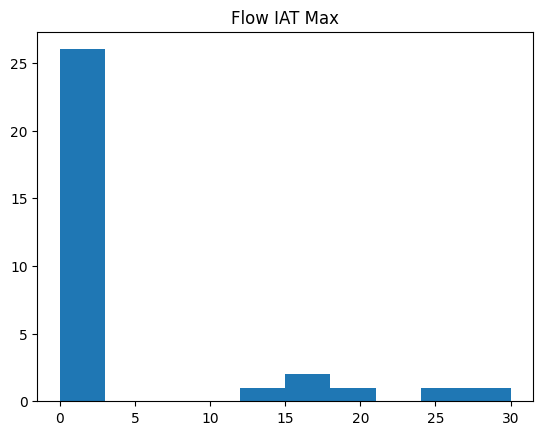

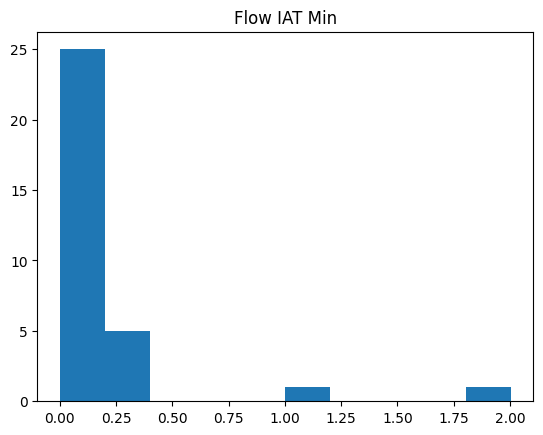

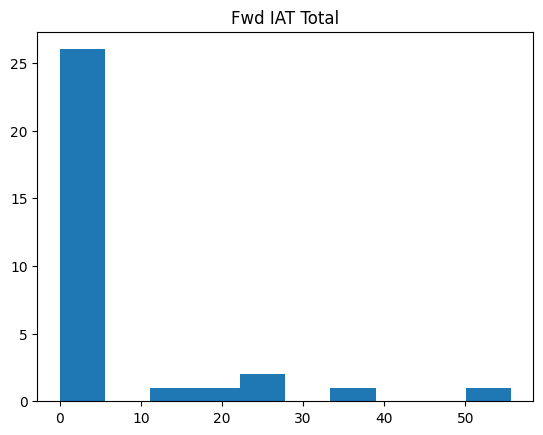

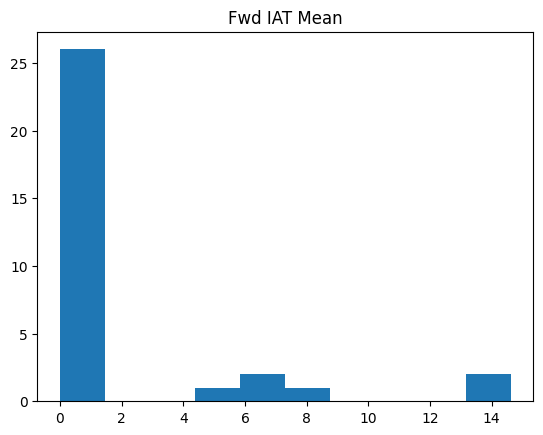

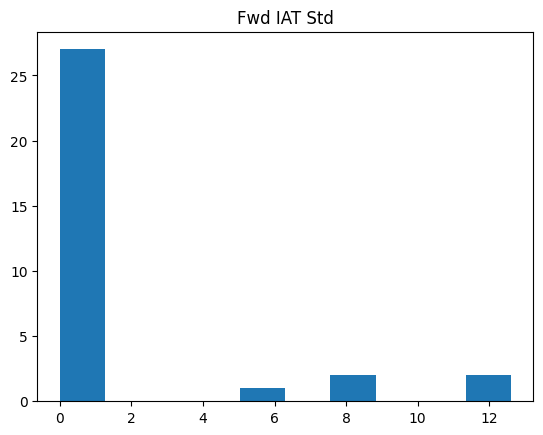

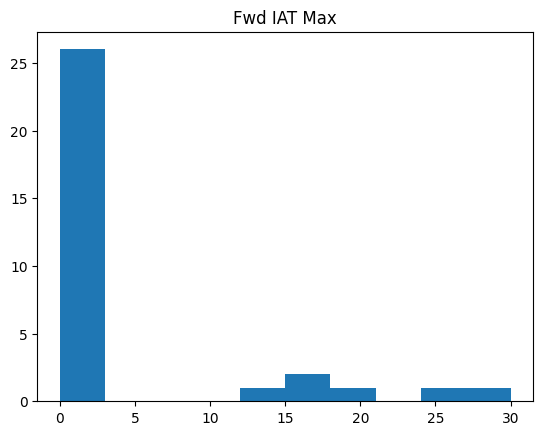

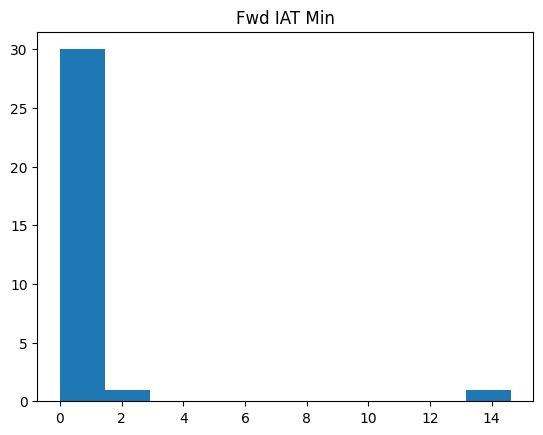

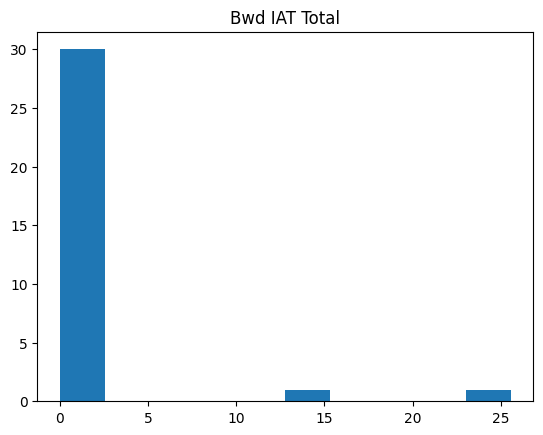

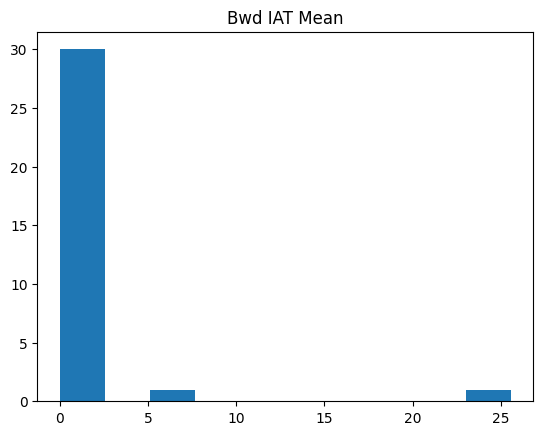

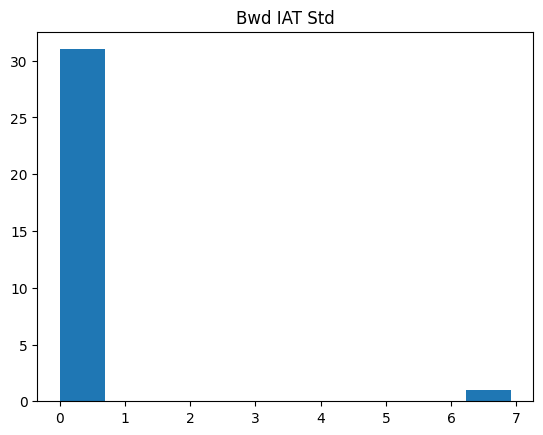

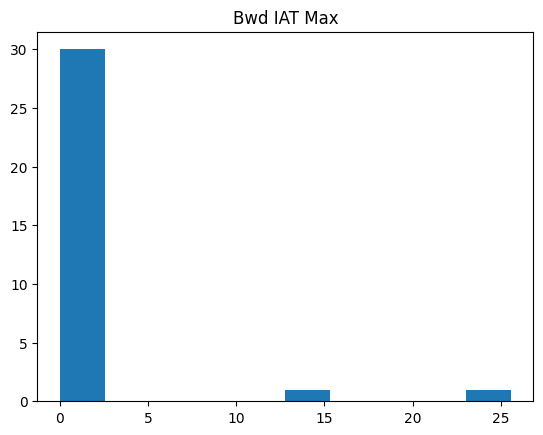

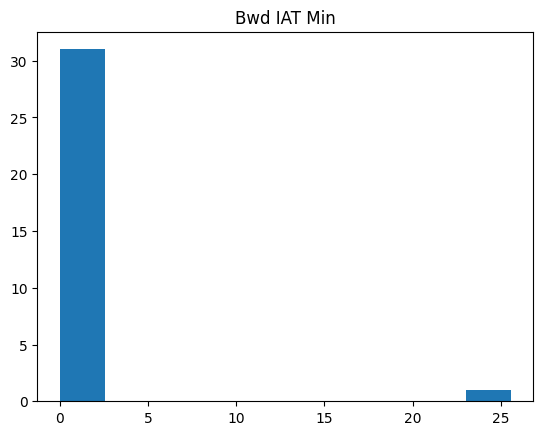

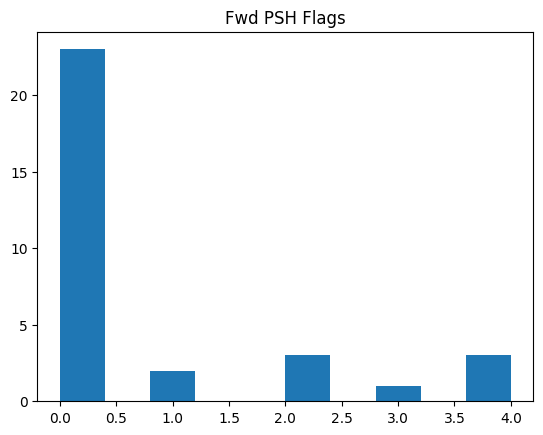

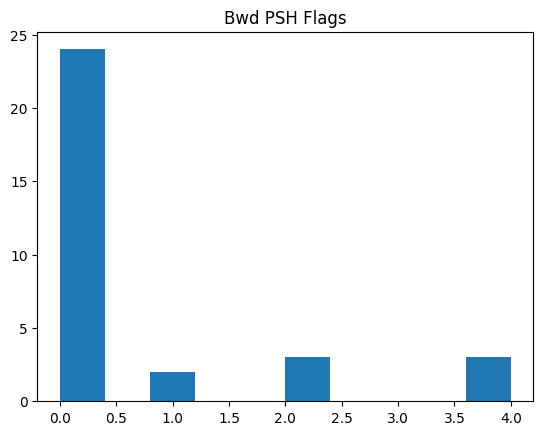

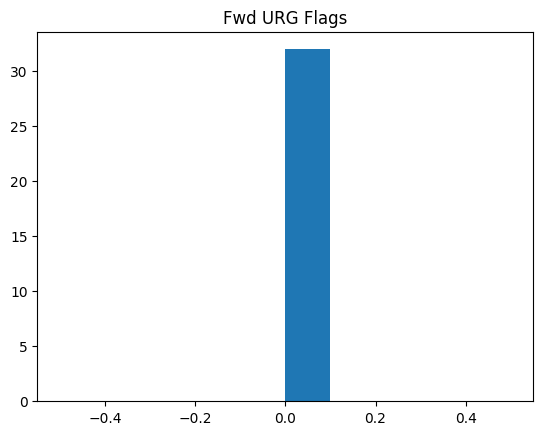

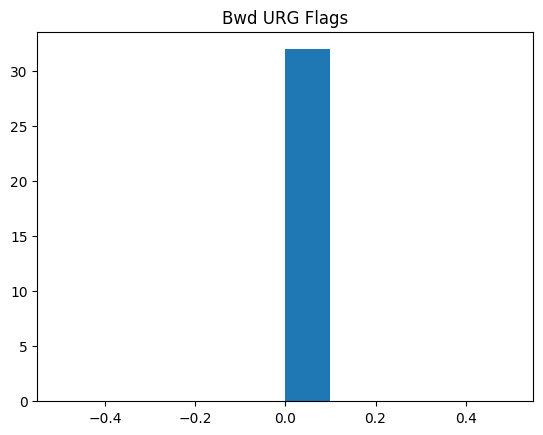

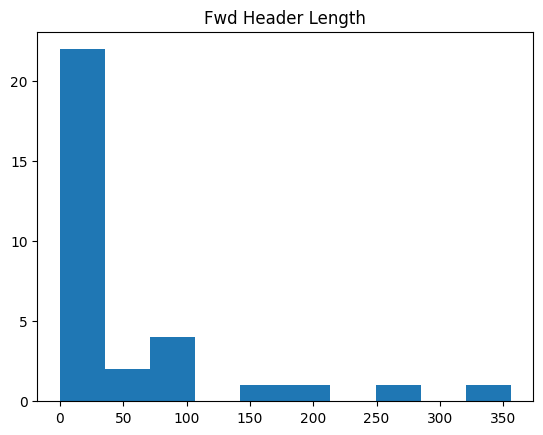

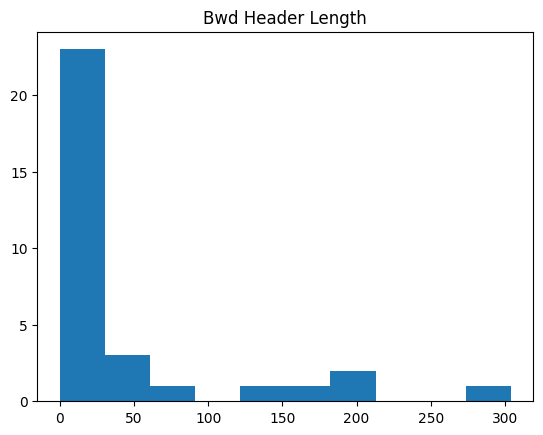

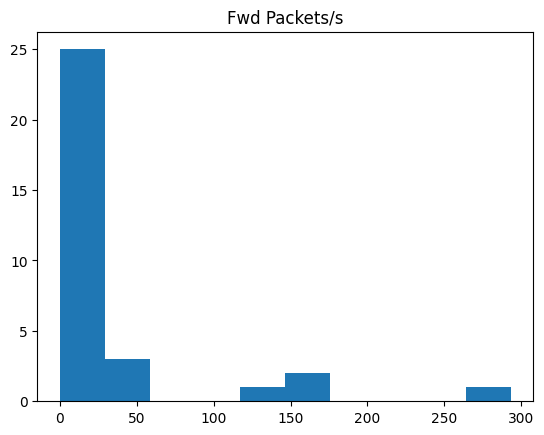

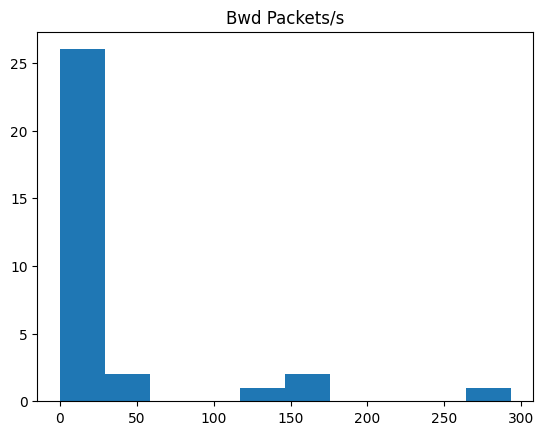

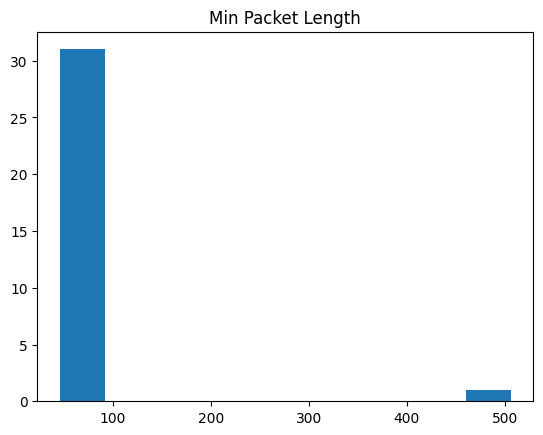

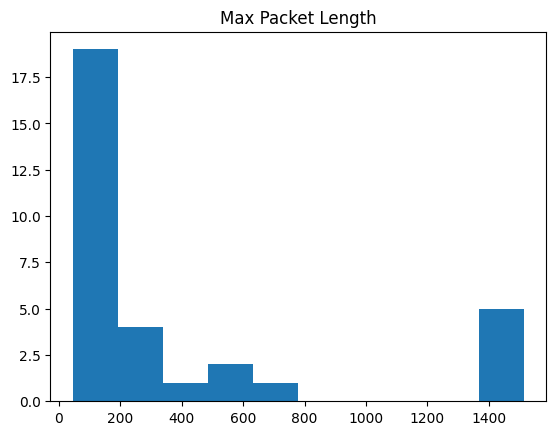

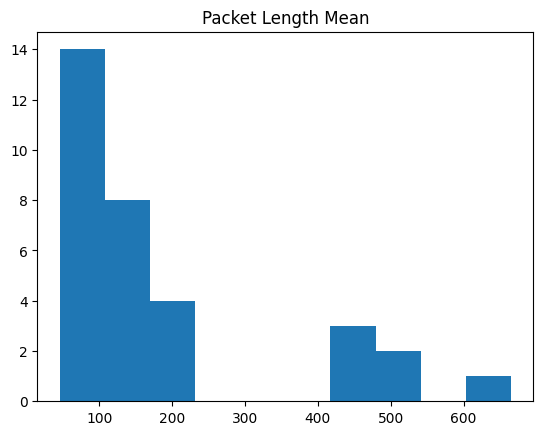

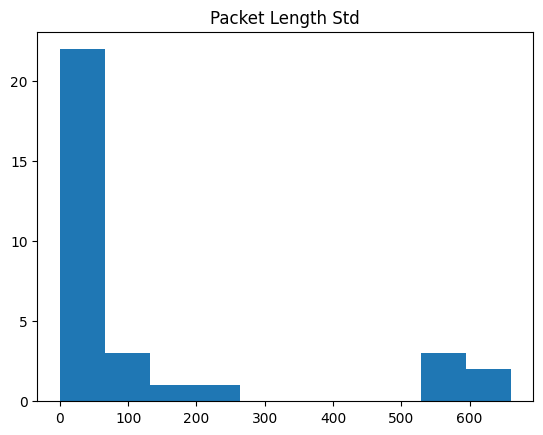

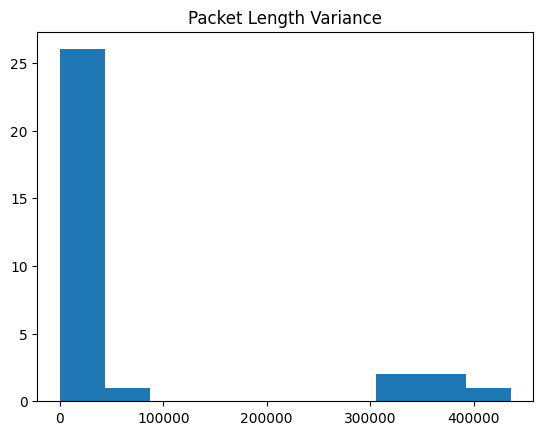

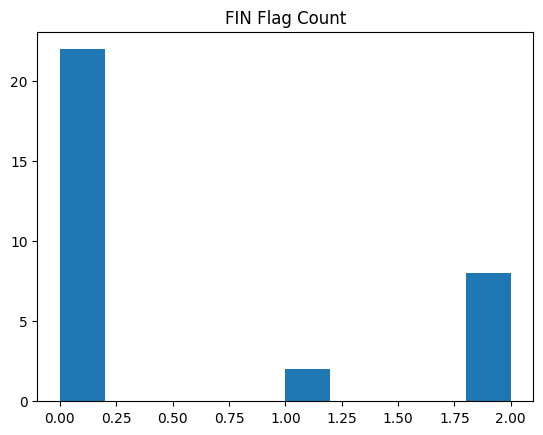

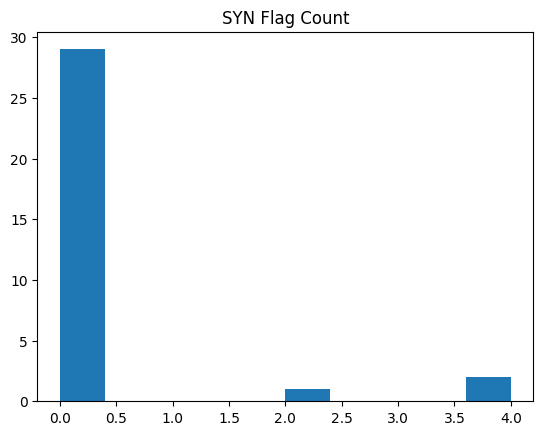

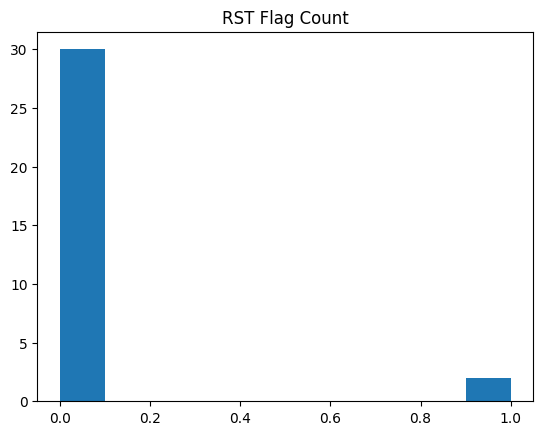

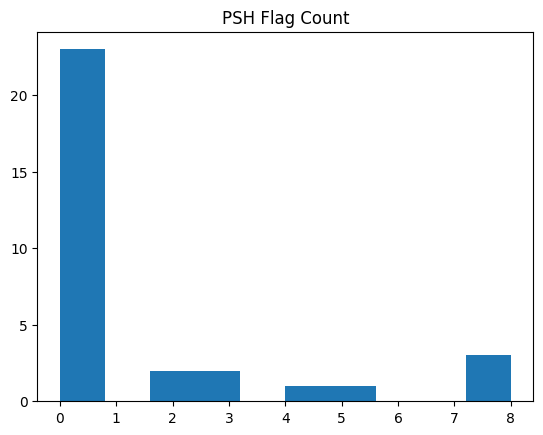

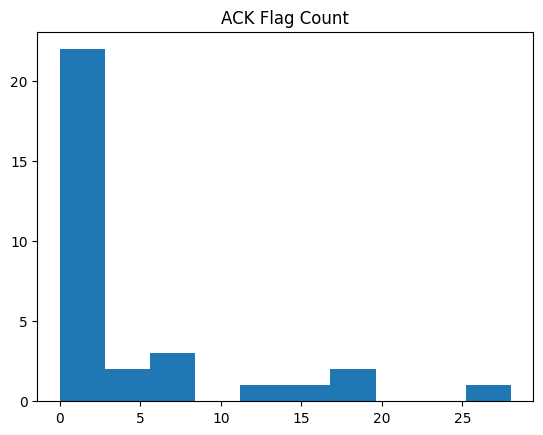

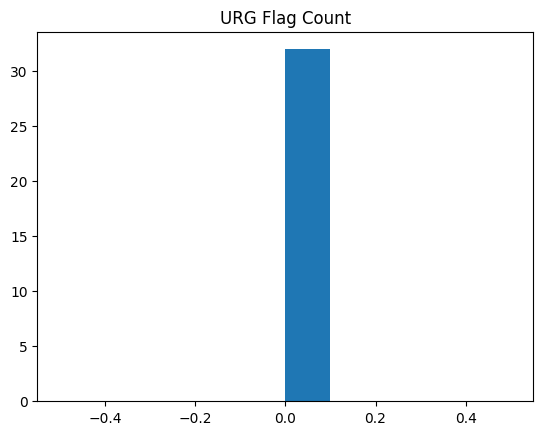

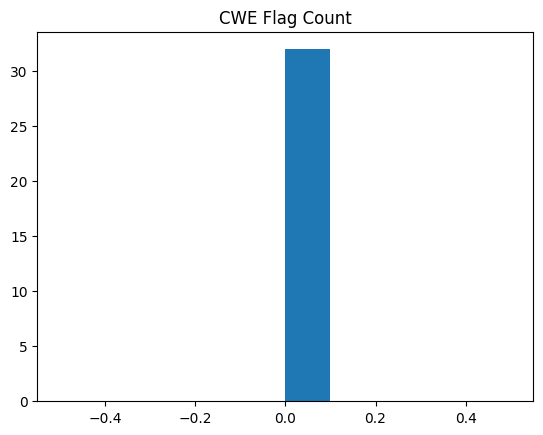

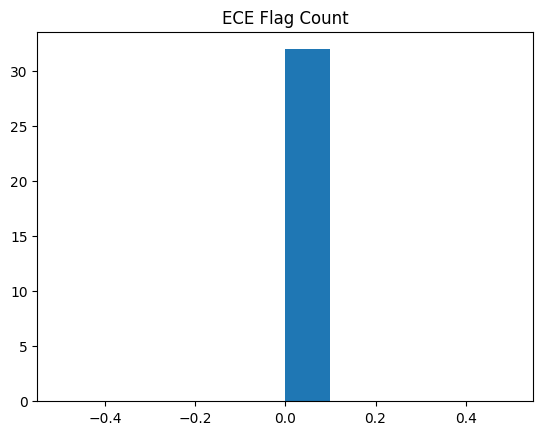

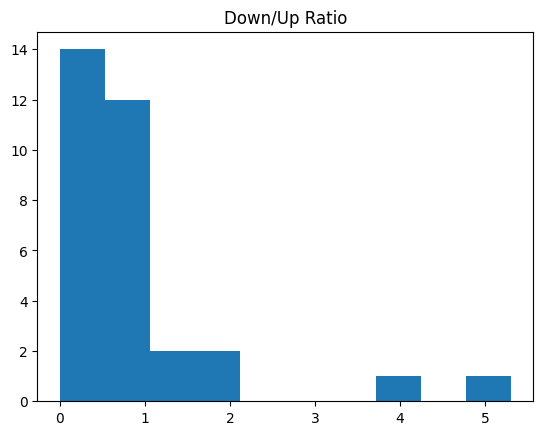

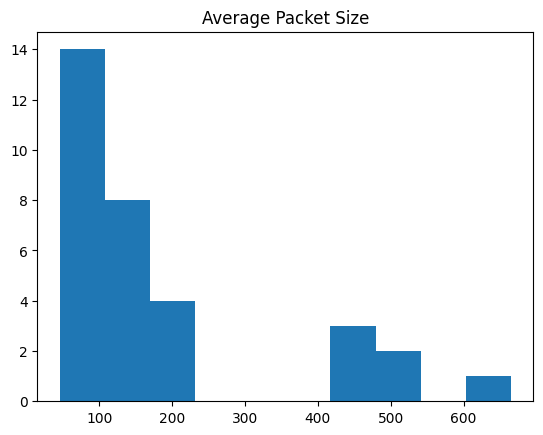

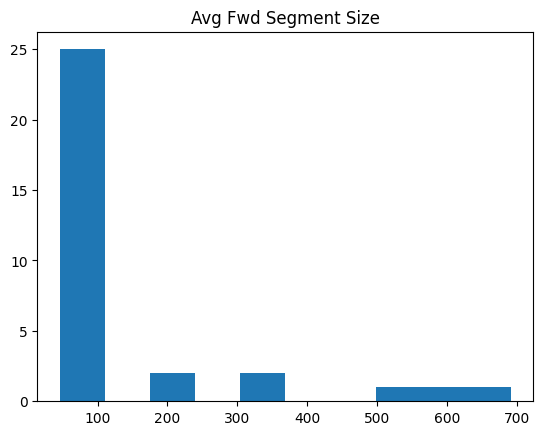

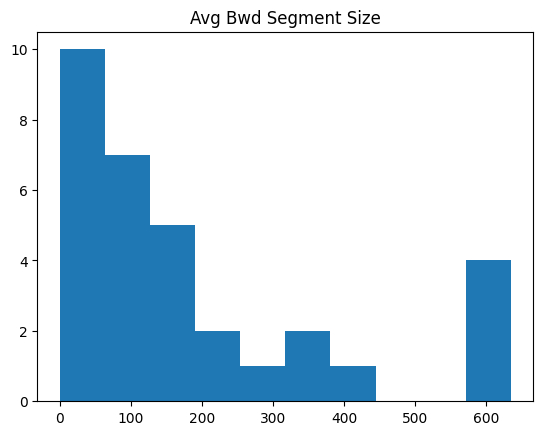

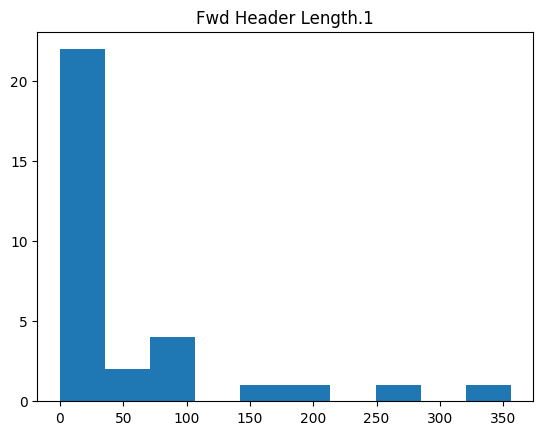

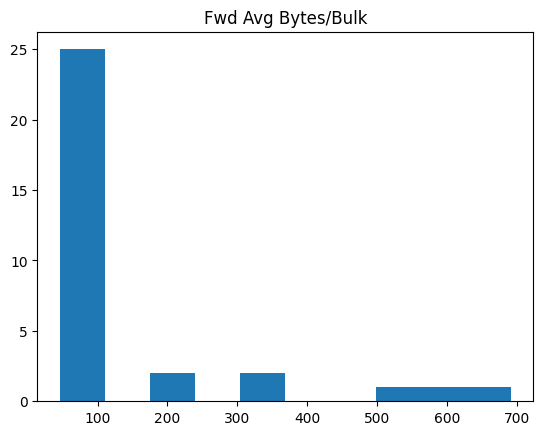

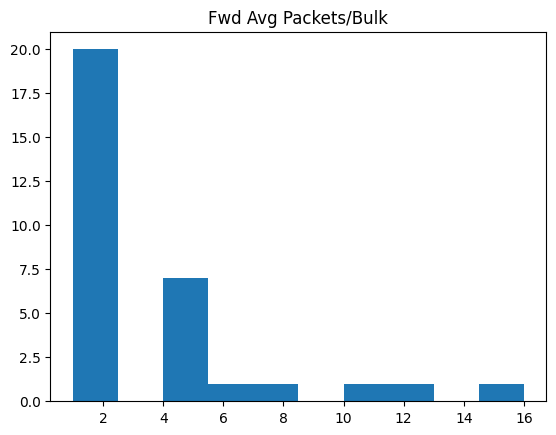

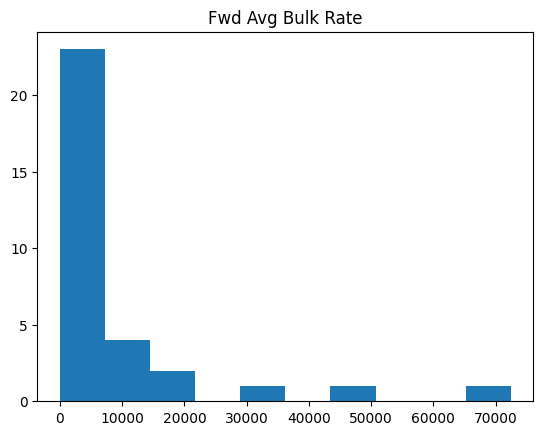

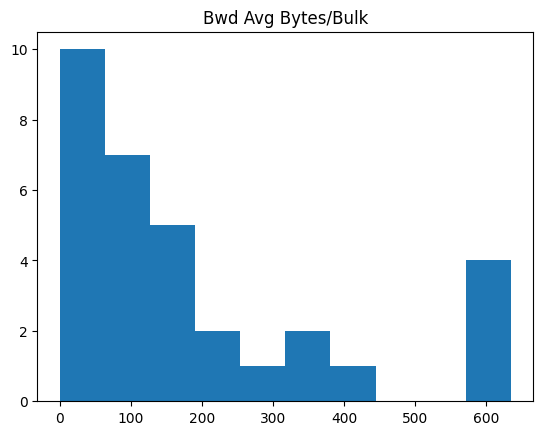

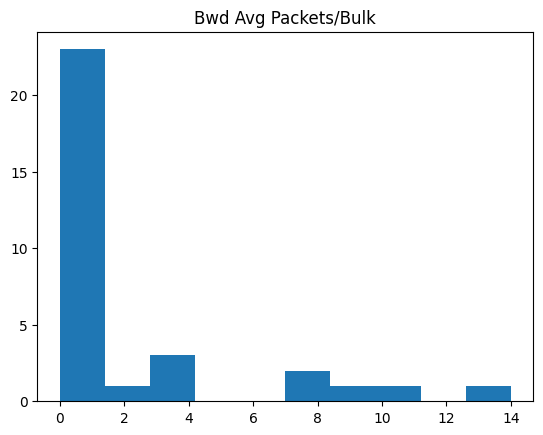

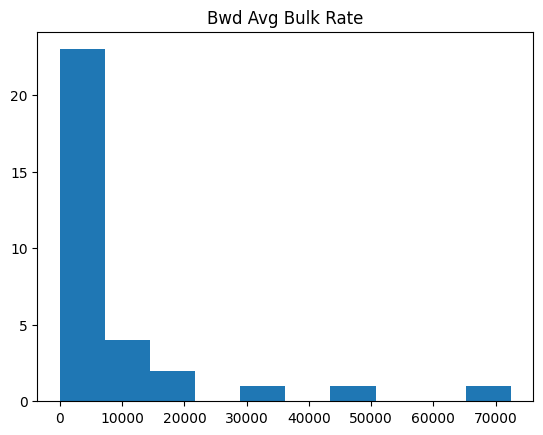

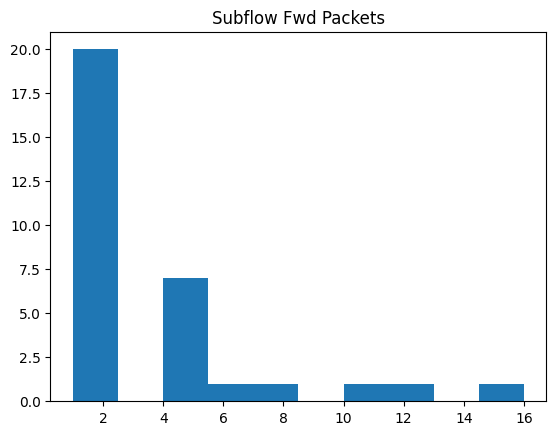

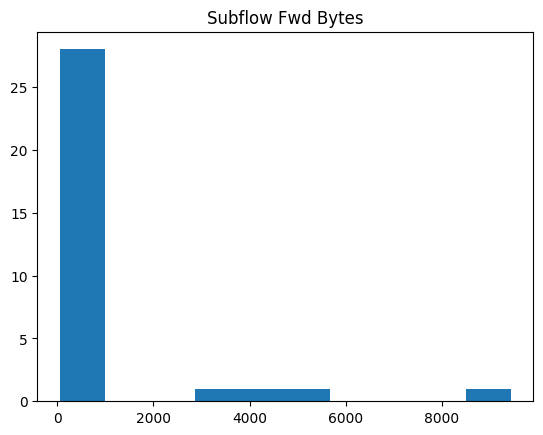

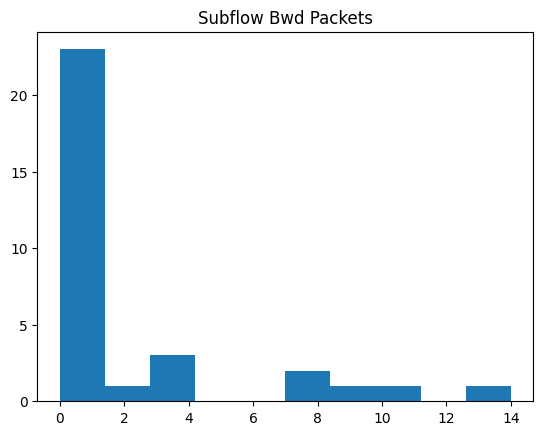

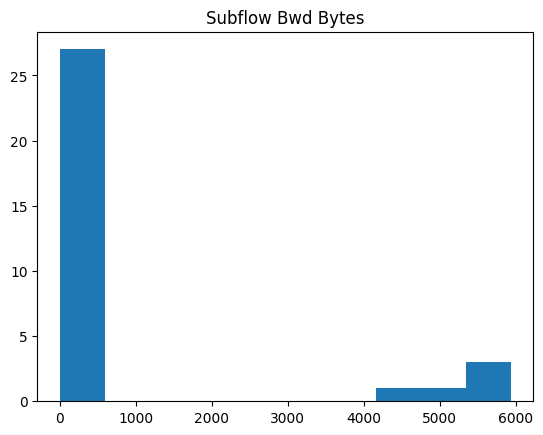

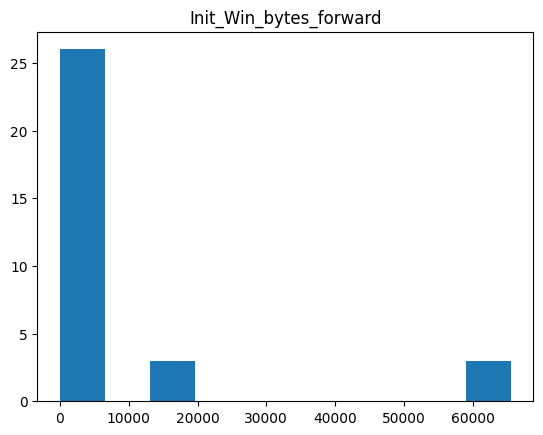

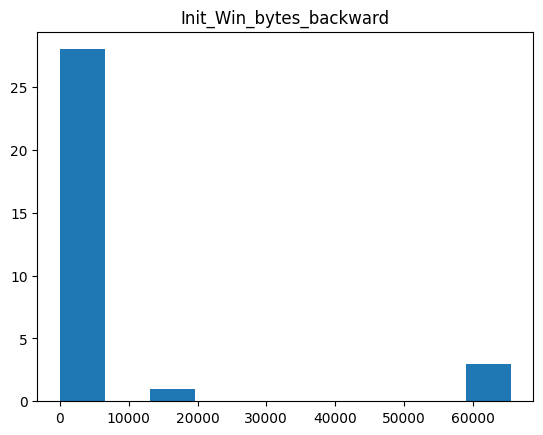

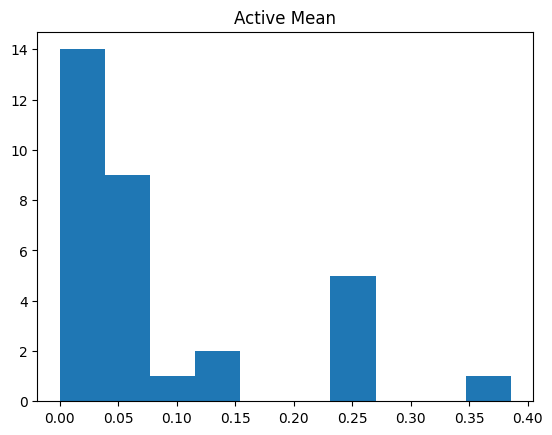

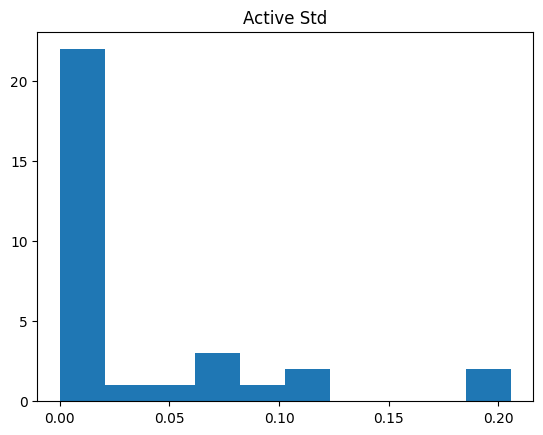

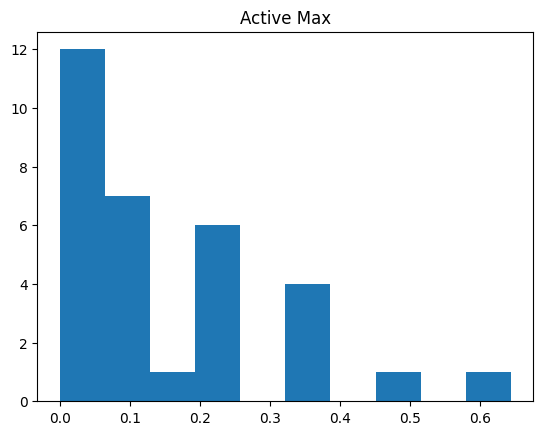

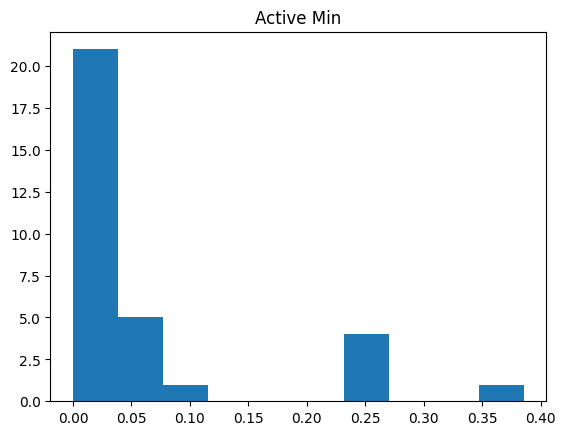

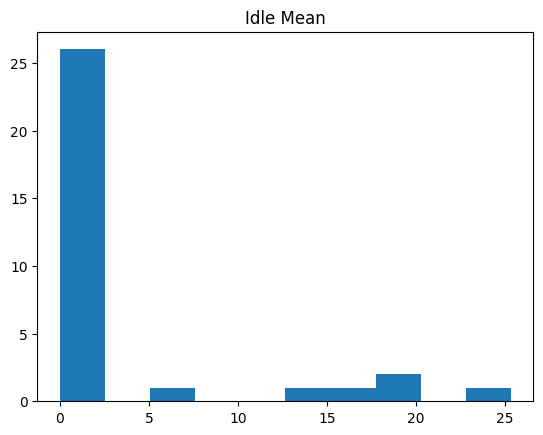

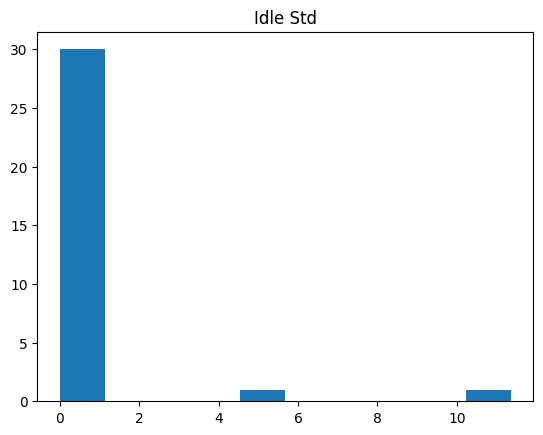

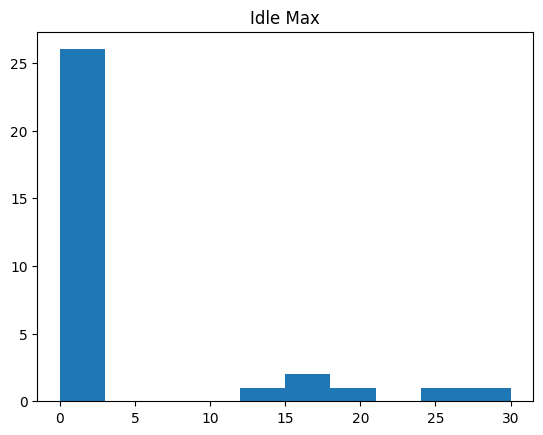

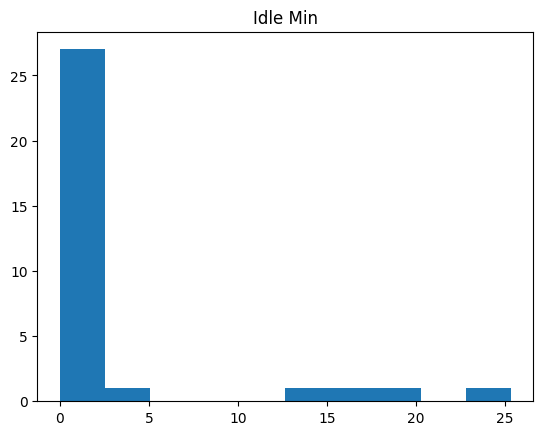

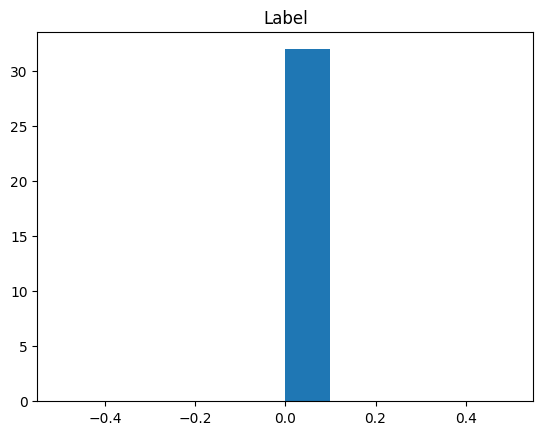

In [29]:
# Creating the histogram for each feature
import matplotlib.pyplot as plt
import seaborn as sns
for fea in test_data.columns:
    plt.figure(5)
    plt.hist(test_data[fea])
    plt.title(fea)
    plt.show()